In [148]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
import warnings
from tqdm import tqdm_notebook as tqdm
import requests
import json
import API
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [131]:
order = pd.read_csv('../codebase/DeliveryRecord.csv')

In [132]:
order.columns

Index(['日期', '門店名稱', '配送地址', '下單時間', '指派成功時間', '騎手接單時間', '到店取餐時間', '取餐出發時間',
       '訂單送達時間', '預送達時間', 'Banner', 'Instant Order', '收貨地址坐標', 'Rider',
       'EstimateArrivalGap', 'TripTime', 'TicketWaitingTime',
       'FoodPreparationTime', 'TotalWaitingTime', 'orderHour', 'storeCode',
       'lat', 'lon'],
      dtype='object')

In [133]:
order['orderTime'] = pd.to_datetime(order['下單時間'])
order['orderMonth'] = pd.to_datetime(order['下單時間']).dt.month
order['orderDate'] = pd.to_datetime(order['下單時間']).dt.day
order['departureTime'] = pd.to_datetime(order['取餐出發時間'])
# order['Origin'] = order.apply(lambda x: Point(float(x['lon']),float(x['lat'])), axis=1)
# order['Destination'] = order['收貨地址坐標'].apply(lambda x: Point(float(x.split(',')[1]),float(x.split(',')[0])))
order['extraTime'] = (pd.to_datetime(order['預送達時間']) - pd.to_datetime(order['訂單送達時間'])) / np.timedelta64(1, 'm')
order = order.sort_values(by=['orderTime'])
order['DLat'] = order['收貨地址坐標'].apply(lambda x: x.split(',')[0])
order['DLon'] = order['收貨地址坐標'].apply(lambda x: x.split(',')[1])
order = order.rename(columns={'lat':'OLat','lon':'OLon'})

In [134]:
order = order.loc[(order['orderMonth']==6)&(order['orderDate']<=3)]

In [135]:
order.columns

Index(['日期', '門店名稱', '配送地址', '下單時間', '指派成功時間', '騎手接單時間', '到店取餐時間', '取餐出發時間',
       '訂單送達時間', '預送達時間', 'Banner', 'Instant Order', '收貨地址坐標', 'Rider',
       'EstimateArrivalGap', 'TripTime', 'TicketWaitingTime',
       'FoodPreparationTime', 'TotalWaitingTime', 'orderHour', 'storeCode',
       'OLat', 'OLon', 'orderTime', 'orderMonth', 'orderDate', 'departureTime',
       'extraTime', 'DLat', 'DLon'],
      dtype='object')

In [137]:
order.shape

(1737, 30)

In [138]:
key = API.key

In [142]:
distanceList = []
endLat = []
endLon = []

In [143]:

for i in tqdm(range(len(order))):
    OLat,OLon,destination = order.iloc[i]['OLat'],order.iloc[i]['OLon'],order.iloc[i]['配送地址']
    url = 'https://maps.googleapis.com/maps/api/directions/json?origin='+str(OLat)+','+\
        str(OLon)+'&destination='+destination+'&mode=walking&key='+key
    data = requests.get(url)
    text = json.loads(data.text)
    if text['routes'] == []:
        distance = 'missing'
        lat = 'missing'
        lon = 'missing'
    else:
        distance = text['routes'][0]['legs'][0]['distance']['text']
        lat = text['routes'][0]['legs'][0]['end_location']['lat']
        lon = text['routes'][0]['legs'][0]['end_location']['lng']
    distanceList += [distance]
    endLat += [lat]
    endLon += [lon]
#     break

In [145]:
order['distance'] = distanceList

In [146]:
order.to_csv('orderDistance0601-0603.csv',index=False)

In [150]:
order = order.loc[order['distance']!='missing']
order['distance'] = order['distance'].apply(lambda x:float(x.split(' ')[0]))

Text(0, 0.5, 'count')

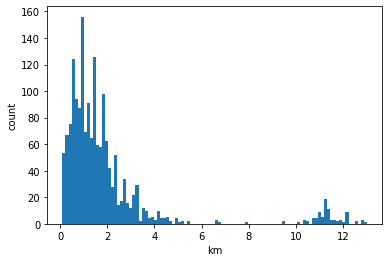

In [153]:
order = order.loc[(order['distance']<20)&(order['distance']>0)]

plt.hist(order['distance'],bins=100)
plt.xlabel('km')
plt.ylabel('count')

In [167]:
order = order[['orderDate','orderMonth','orderTime']]

Index(['日期', '門店名稱', '配送地址', '下單時間', '指派成功時間', '騎手接單時間', '到店取餐時間', '取餐出發時間',
       '訂單送達時間', '預送達時間', 'Banner', 'Instant Order', '收貨地址坐標', 'Rider',
       'EstimateArrivalGap', 'TripTime', 'TicketWaitingTime',
       'FoodPreparationTime', 'TotalWaitingTime', 'orderHour', 'storeCode',
       'OLat', 'OLon', 'orderTime', 'orderMonth', 'orderDate', 'departureTime',
       'extraTime', 'DLat', 'DLon', 'distance', 'walkingDuration',
       'walkingEST'],
      dtype='object')

In [166]:
#walking speed 5km/hour
order['walkingDuration'] = order['distance']/5*60
order['walkingEST'] = order['departureTime']+pd.to_timedelta(order['walkingDuration'], unit='minutes')

In [168]:
order['gapWalkEstimate'] = (pd.to_datetime(order['預送達時間']) - pd.to_datetime(order['walkingEST'])) / np.timedelta64(1, 'm')

In [169]:
order['gapWalkEstimate'].describe()

count    1712.000000
mean        0.884540
std        32.694998
min      -142.200000
25%        -3.112500
50%         7.816667
75%        16.566667
max        92.483333
Name: gapWalkEstimate, dtype: float64

In [181]:
#e-bike speed 25km/hour
order['EBikeDuration'] = order['distance']/25*60
order['EBikeEST'] = order['departureTime']+pd.to_timedelta(order['EBikeDuration'], unit='minutes')
order['gapEBikEstimate'] = (pd.to_datetime(order['預送達時間']) - 
                            pd.to_datetime(order['EBikeEST'])) / np.timedelta64(1, 'm')

In [182]:
order['EBikeDuration'].describe()

count    1712.000000
mean        4.711121
std         5.714594
min         0.240000
25%         1.920000
50%         3.120000
75%         4.860000
max        31.200000
Name: EBikeDuration, dtype: float64

Text(0, 0.5, 'count')

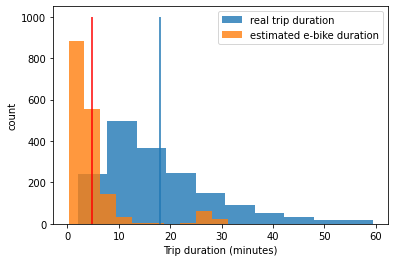

In [192]:
plt.hist(order['TripTime'],label='real trip duration',alpha=0.8)
plt.vlines(order['TripTime'].mean(),ymin=0,ymax=1000)
plt.hist(order['EBikeDuration'],label='estimated e-bike duration',alpha=0.8)
plt.vlines(order['EBikeDuration'].mean(),ymin=0,ymax=1000,color='red')
plt.legend()
plt.xlabel('Trip duration (minutes)')
plt.ylabel('count')

In [193]:
order.to_csv('orderDistance0601-0603.csv',index=False)

In [194]:
order['CombineWith'] = 0

In [ ]:
for i in tqdm(range(len(order))):
# for i in range(10):
    if order.iloc[i]['CombineWith'] == 0:
        extraTime = order.iloc[i]['extraTime']
        departureTime = order.iloc[i]['departureTime']
        Origin = order.iloc[i]['Origin']
        Destination = order.iloc[i]['Destination']
        TripTime = order.iloc[i]['TripTime']
        TripLength = LineString([Origin,Destination]).length
        speed = TripLength / TripTime
        bufferDist = speed * extraTime
        TotalTime1 = TripTime + extraTime
        
'''        dataset is sorted by order time, so ridesharing candidates have to be orders later than 
        the current selected one'''

        candidate = order.iloc[i+1:]
        candidate = candidate.loc[candidate['CombineWith'] == 0]
        '''order ready to pick time should be earlier than order 1 departure time + order 1 extra time, 
        otherwise we will waste all the extra time on waiting for the second order'''
        candidate = candidate.loc[((candidate['departureTime'] - departureTime) / np.timedelta64(1, 'm')) < extraTime]
        '''trip duration between two origins and two destinations cannot be longer than order 1 extra time,
        use buffer zone to filter'''
        candidate['OriginIn'] = candidate['Origin'].apply(lambda x: Origin.buffer(bufferDist).intersects(x))
        candidate['DestinationIn'] = candidate['Destination'].apply(lambda x: Destination.buffer(bufferDist).intersects(x))
        candidate = candidate.loc[(candidate['OriginIn']==True)&(candidate['DestinationIn']==True)]
        
        '''4 potention path: O1-O2-D1-D2, O1-O2-D2-D1, O2-O1-D1-D2, O2-O1-D2-D1, calculate arrival time for each order,
        if both order could be delivered before estimated time, stop calculation'''
        if len(candidate) > 0:
            for ind in candidate.index.tolist():
                combined = 0
                candidateSelect = candidate.loc[candidate.index==ind]
                Origin2 = candidateSelect.iloc[0]['Origin']
                Destination2 = candidateSelect.iloc[0]['Destination']
                TripTime2 = candidateSelect.iloc[0]['TripTime']
                extraTime2 = candidateSelect.iloc[0]['extraTime']
                TotalTime2 = TripTime2 + extraTime2
       
                path1 = LineString([Origin,Origin2,Destination])
                Order1Time = path1.length / speed
                path2 = LineString([Origin,Origin2,Destination,Destination2])
                Order2Time = path2.length / speed
                
                if Order1Time < TotalTime1 and Order2Time < TotalTime2:
                    order.loc[order.index==ind,'CombineWith'] = i
                    order.loc[order.index==i,'CombineWith'] = ind
                    
                    order.loc[order.index==i,'path'] = 'Origin1,Origin2,Destination1,Destination2'
                    order.loc[order.index==ind,'path'] = 'Origin1,Origin2,Destination1,Destination2'
                    
                    combined = 1
                else:
                    path1 = LineString([Origin,Origin2,Destination2,Destination])
                    Order1Time = path1.length / speed
                    path2 = LineString([Origin,Origin2,Destination2])
                    Order2Time = path1.length / speed
                    if Order1Time < TotalTime1 and Order2Time < TotalTime2:
                        order.loc[order.index==ind,'CombineWith'] = i
                        order.loc[order.index==i,'CombineWith'] = ind
                        order.loc[order.index==i,'path'] = 'Origin1,Origin2,Destination2,Destination1'
                        order.loc[order.index==ind,'path'] = 'Origin1,Origin2,Destination2,Destination1'
                        
                        combined = 1
                    else:
                        path1 = LineString([Origin2,Origin,Destination])
                        Order1Time = path1.length / speed
                        path2 = LineString([Origin2,Origin,Destination,Destination2])
                        Order2Time = path1.length / speed
                        if Order1Time < TotalTime1 and Order2Time < TotalTime2:
                            order.loc[order.index==ind,'CombineWith'] = i
                            order.loc[order.index==i,'CombineWith'] = ind
                            order.loc[order.index==i,'path'] = 'Origin2,Origin1,Destination1,Destination2'
                            order.loc[order.index==ind,'path'] = 'Origin2,Origin1,Destination1,Destination2'
                            
                            combined = 1
                        else:
                            path1 = LineString([Origin2,Origin,Destination2,Destination])
                            Order1Time = path1.length / speed
                            path2 = LineString([Origin2,Origin,Destination2])
                            Order2Time = path1.length / speed
                        if Order1Time < TotalTime1 and Order2Time < TotalTime2:
                            order.loc[order.index==ind,'CombineWith'] = i
                            order.loc[order.index==i,'CombineWith'] = ind
                            order.loc[order.index==i,'path'] = 'Origin2,Origin1,Destination2,Destination1'
                            order.loc[order.index==ind,'path'] = 'Origin2,Origin1,Destination2,Destination1'
                            
                            combined = 1
                if combined > 0:
                    next
                            
                            